In [78]:
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [2]:
df = pd.read_csv('diabetes.csv', encoding='cp1251')
df.head()

keys = list(df.keys())
keys.remove('Outcome') # исключаем зависимую переменную Outcome
for key in keys:
  df = df[df[key] > 0]
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
3,1,89,66,23,94,28.1,0.167,21,0
6,3,78,50,32,88,31.0,0.248,26,1
8,2,197,70,45,543,30.5,0.158,53,1
13,1,189,60,23,846,30.1,0.398,59,1
14,5,166,72,19,175,25.8,0.587,51,1


In [3]:
df.shape

(336, 9)

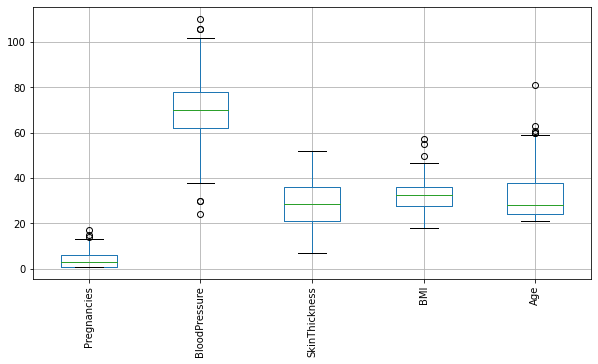

In [4]:
def remove_outliers(samples):
  """Удаляет выбросы из данных"""
  q1 = samples.quantile(0.25)
  q3 = samples.quantile(0.75)
  iqr = q3 - q1
  boxplot_range = (q1 - 1.5 * iqr, q3 + 1.5 * iqr)
  return df.loc[(samples >= boxplot_range[0]) & (samples <= boxplot_range[1])]

# Посмотрим какие факторы имеют выбросы

df[['Pregnancies', 'BloodPressure', 'SkinThickness', 'BMI', 'Age']].boxplot(rot=90, figsize=(10, 5))

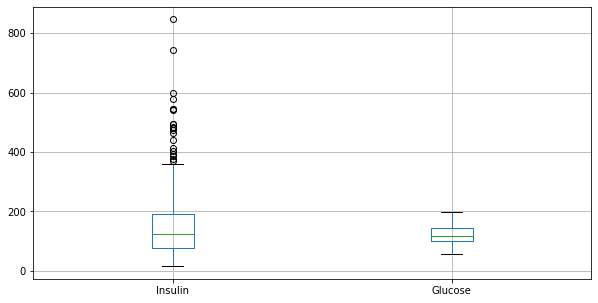

In [5]:
df[['Insulin', 'Glucose']].boxplot(figsize=(10, 5))

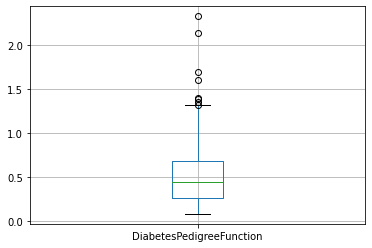

In [6]:
df[['DiabetesPedigreeFunction']].boxplot()

In [7]:
# Удалим выбросы

df = remove_outliers(df['Pregnancies'])
df = remove_outliers(df['BloodPressure'])
df = remove_outliers(df['BMI'])
df = remove_outliers(df['Age'])
df = remove_outliers(df['Insulin'])
df = remove_outliers(df['DiabetesPedigreeFunction'])

In [8]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000
mean,3.552083,118.690972,69.979167,28.003472,126.479167,31.814931,0.499090,30.326389,0.295139
std,2.815598,29.095990,11.153955,10.063387,69.547213,6.000321,0.283695,8.605022,0.456899
min,1.000000,56.000000,38.000000,7.000000,15.000000,18.200000,0.085000,21.000000,0.000000
25%,1.000000,97.000000,62.000000,20.000000,71.000000,27.425000,0.267750,24.000000,0.000000
50%,3.000000,114.500000,70.000000,28.000000,115.000000,32.300000,0.436000,28.000000,0.000000
75%,5.000000,136.000000,78.000000,35.000000,168.000000,35.575000,0.678000,36.000000,1.000000
max,13.000000,196.000000,102.000000,52.000000,335.000000,46.700000,1.321000,55.000000,1.000000


In [9]:
# Посчитаем несмещенную выборочную дисперсию для каждого фактора

print(df.var(ddof=1))

Pregnancies                    7.927591
Glucose                      846.576643
BloodPressure                124.410714
SkinThickness                101.271765
Insulin                     4836.814895
BMI                           36.003853
DiabetesPedigreeFunction       0.080483
Age                           74.046409
Outcome                        0.208757
dtype: float64


In [10]:
# Посчитаем моду для каждого фактора

print(df['Pregnancies'].mode())
print(df['Glucose'].mode())
print(df['BloodPressure'].mode())
print(df['SkinThickness'].mode())
print(df['Insulin'].mode())
print(df['BMI'].mode())
print(df['DiabetesPedigreeFunction'].mode())
print(df['Age'].mode())

0    1
dtype: int64
0    100
dtype: int64
0    74
dtype: int64
0    30
1    32
dtype: int64
0    140
dtype: int64
0    31.6
1    33.3
dtype: float64
0    0.692
dtype: float64
0    22
dtype: int64


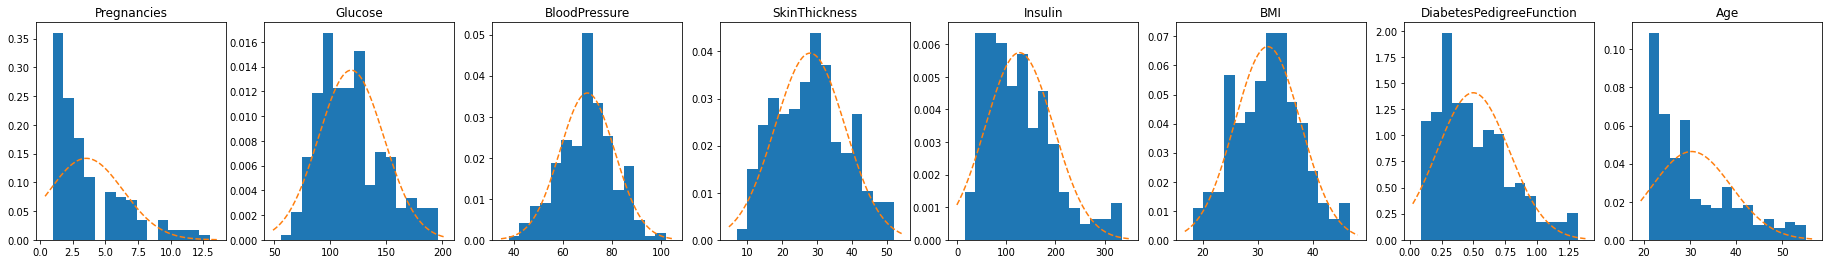

In [11]:
# Построим гистограмы с проверкой на нормальность для каждого фактора

keys = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
fig, axes = plt.subplots(ncols=len(keys))
fig.set_size_inches(4 * len(keys), 4)
axes = axes.flatten()
for key, ax in zip(keys, axes):
  ax.hist(df[key], density=True, bins=15)
  loc = df[key].mean()
  scale = df[key].std()
  x_left, x_right = ax.get_xlim()
  x = np.linspace(x_left, x_right, 10000)
  y = stats.norm.pdf(x, loc=loc, scale=scale)
  ax.plot(x, y, linestyle='dashed')
  ax.set_title(key)

# 'Pregnancies' - распределение похоже на экспоненциальное или Фишера
# 'Glucose' - распределение похоже на Колмогорова
# 'BloodPressure' - распределение похоже на нормальное
# 'SkinThickness' - распределение похоже на Колмогорова
# 'Insulin' - распределение похоже на Колмогорова
# 'BMI' - распределение похоже на нормальное
# 'DiabetesPedigreeFunction' - распределение похоже на Колмогорова
# 'Age' - распределение похоже на экспоненциальное или Фишера

In [12]:
# Проверим гипотезу H0: 'Glucose' распределена нормально
# H1: 'Glucose' не распределена нормально

alpha = 0.05
stat, p = stats.normaltest(df['Glucose'])
print(f'Statistics = {round(stat, 3)}, p-value = {round(p, 3)}')

# H0 отвергается на уровне значимости 0.05. 'Glucose' не распределена нормально

Statistics = 16.678, p-value = 0.0


In [13]:
# Проверим гипотезу H0: 'BMI' распределена нормально
# H1: 'BMI' не распределена нормально

alpha = 0.05
stat, p = stats.normaltest(df['BMI'])
print(f'Statistics = {round(stat, 3)}, p-value = {round(p, 3)}')

# H0 принимается на уровне значимости 0.05. 'BMI' распределена нормально

Statistics = 2.235, p-value = 0.327


In [14]:
# Проверим гипотезу H0: 'BloodPressure' распределена нормально
# H1: 'BloodPressure' не распределена нормально

alpha = 0.05
stat, p = stats.normaltest(df['BloodPressure'])
print(f'Statistics = {round(stat, 3)}, p-value = {round(p, 3)}')

# H0 принимается на уровне значимости 0.05. 'BloodPressure' распределена нормально

Statistics = 1.035, p-value = 0.596


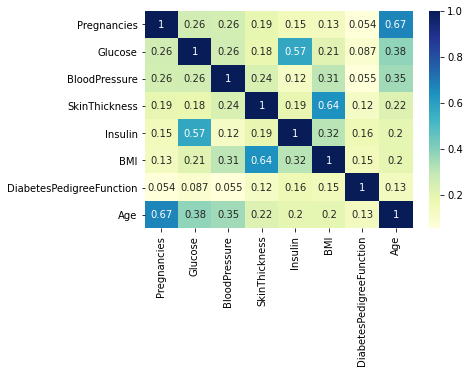

In [15]:
dataplot = sns.heatmap(df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']].corr(), cmap="YlGnBu", annot=True)

# Корреляция возраста и количества беременностей достаточно высока. Можно сделать вывод, что, как правило, чем старше женщина, тем больше беременностей она перенесла

In [16]:
# Вспомогательные функции для исследования логистической регрессии

def sigmoid(x: float) -> float:
    """Сигмоида.
    """
    
    return 1 / (1 + np.exp(-x))

def partial_derivative(j: int, b: np.ndarray, x: np.ndarray, y: np.ndarray) -> float:
    """Частная производная функционала Q по переменной b_j.
    """
    
    return sum(
        x[i, j] * (y[i] - sigmoid(b.dot(x[i])))
        for i in range(x.shape[0])
    )

def gradient(b: np.ndarray, x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """Вектор градиента.
    """
    
    return np.array([
        partial_derivative(j, b, x, y)
        for j in range(b.shape[0])
    ])

def gradient_descent_step(
        lambda_: float,
        b: np.ndarray,
        x: np.ndarray,
        y: np.ndarray,
) -> np.ndarray:
    """Один шаг градиентного спуска.
    """
    
    return b + lambda_ * gradient(b, x, y)

In [17]:
x = np.array([df['Pregnancies'], df['Glucose'], df['BloodPressure'], df['SkinThickness'], df['Insulin'], df['BMI'], df['DiabetesPedigreeFunction'], df['Age']]).T
y = np.array(df['Outcome'])
x = (x - x.min(axis=0)) / (x.max(axis=0) - x.min(axis=0))
ones = np.ones((x.shape[0], 1))
x1 = np.hstack([ones, x])
print(x1)

[[1.         0.         0.23571429 ... 0.34736842 0.06634304 0.        ]
 [1.         0.16666667 0.15714286 ... 0.44912281 0.13187702 0.14705882]
 [1.         0.33333333 0.78571429 ... 0.26666667 0.40614887 0.88235294]
 ...
 [1.         0.         0.51428571 ... 0.64210526 0.78640777 0.47058824]
 [1.         0.08333333 0.22857143 ... 0.35789474 0.55097087 0.02941176]
 [1.         0.33333333 0.46428571 ... 0.28070175 0.12944984 0.26470588]]


In [18]:
# Найдем коэффициенты методом градиентного спуска

from scipy.spatial.distance import euclidean
b_0 = np.zeros(x1.shape[1])
b = b_0
for k in range(1, 10 ** 6):
    lambda_ = 0.1 / k
    b_new = gradient_descent_step(lambda_, b, x1, y)   
    if euclidean(b, b_new) < 10 ** (-5):
        print(f'success on step {k}\n')
        break
    b = b_new
b = b_new
print(b)

# Получатся такие коэффициенты:

# success on step 22356
# [-5.12295086  0.59418352  3.47033564  0.10709921  0.6725493   1.50247404
#   0.5677249   1.76660136  1.91920704]

success on step 22356

[-5.12295086  0.59418352  3.47033564  0.10709921  0.6725493   1.50247404
  0.5677249   1.76660136  1.91920704]


In [19]:
# Найдем те же коэффициенты с использованием функций библиотеки sklearn

model = LogisticRegression(solver='liblinear', fit_intercept=False)
model.fit(x1, y)
b_sklearn = model.coef_.flatten()
print(f'Коэффициенты: {b_sklearn}')
print(f'Число итераций: {model.n_iter_}')

Коэффициенты: [-3.80748389  0.53489023  2.51675341  0.08001912  0.43979244  1.03991328
  0.34887213  1.22321546  1.45292341]
Число итераций: [5]


In [27]:
# Получим вектор из вероятностей того, что при определеннызх факторах 'Outcome' равен 1

z = x1.dot(b_sklearn)
sigma_z = np.array([sigmoid(z_i) for z_i in z])
print(sigma_z)

[0.07150467 0.09156975 0.71091624 0.24813082 0.44449657 0.65170766
 0.38132842 0.11412877 0.60226443 0.0660755  0.37370427 0.37498255
 0.10028934 0.1077874  0.10515034 0.79656465 0.31977724 0.07561297
 0.2620982  0.21195961 0.31839915 0.28722973 0.23412567 0.24272641
 0.13263817 0.32373567 0.23318642 0.24111537 0.52494606 0.05144685
 0.11524474 0.06298346 0.26322888 0.39331964 0.08728601 0.36852229
 0.07720989 0.62980908 0.07868907 0.15311288 0.29673325 0.15666181
 0.32440391 0.49046875 0.54772708 0.11589952 0.20743196 0.29274016
 0.11706077 0.41127929 0.35071393 0.77800193 0.11785981 0.19877015
 0.07014751 0.3368952  0.38161347 0.17675145 0.3525982  0.12617879
 0.10367073 0.71502316 0.48471223 0.31747738 0.3248368  0.42365975
 0.5339765  0.13287604 0.30459487 0.43767516 0.08819149 0.5109963
 0.0961327  0.35095443 0.7774107  0.24366065 0.32057923 0.12838504
 0.06355649 0.07796123 0.06770887 0.81322144 0.12558061 0.51867195
 0.39796003 0.07348244 0.51996845 0.53014473 0.36414782 0.09176

In [75]:
y_hat_arr = np.array([], dtype=int)
for el in sigma_z:
  if el > 0.5:
    y_hat = 1
  else:
    y_hat = 0
  y_hat_arr = np.append(y_hat_arr, y_hat)
print(y_hat_arr)
print(y)

[0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0
 1 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1
 0 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 1 0
 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 1 0 0]
[0 1 1 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 1 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 1 1 0 1 1 1 1 0 0 0 1
 1 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 1 1 1 0 0 0
 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0
 0 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 0

In [79]:
# Важность признаков

A = df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']]
B = df.iloc[:, -1]

bestfeatures = SelectKBest(score_func = chi2, k = 'all')
fit = bestfeatures.fit(A, B)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(A.columns)

featureScores = pd.concat([dfcolumns, dfscores], axis = 1)
featureScores.columns = ['Specs', 'Score']  
print(featureScores.nlargest(10, 'Score'))  

                      Specs        Score
4                   Insulin  1482.100256
1                   Glucose   558.155331
7                       Age   112.571204
3             SkinThickness    61.685187
0               Pregnancies    54.881772
2             BloodPressure    33.321119
5                       BMI    20.698562
6  DiabetesPedigreeFunction     3.166309


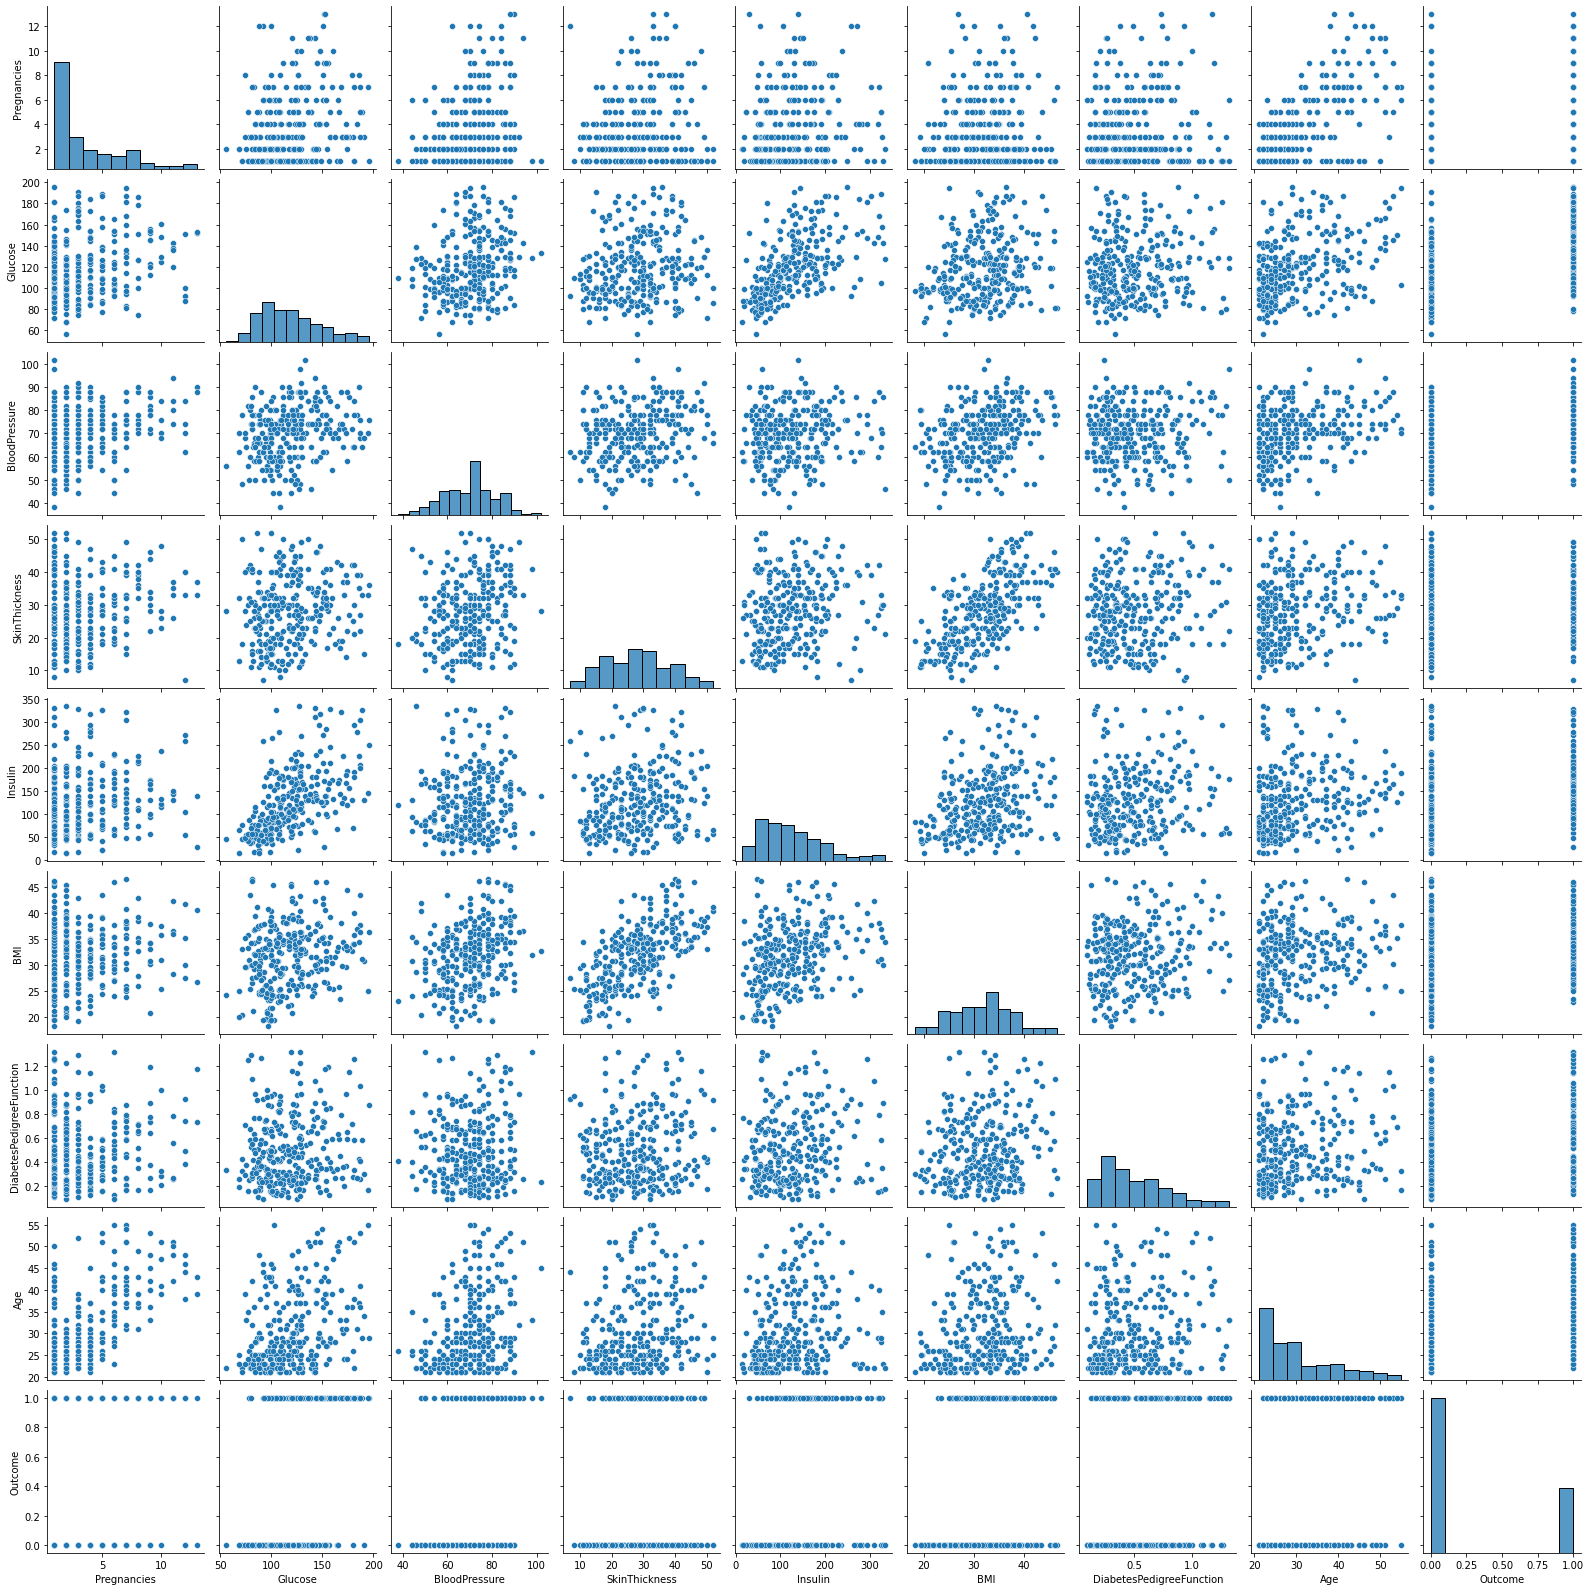

In [77]:
sns.pairplot(df)